Iniciando proceso de extracción y análisis de películas...
Análisis de sentimiento para: 'Excellent movie with a fascinating plot. Highly re...': 0.58
Análisis de sentimiento para: 'One of the best films I've ever seen. The narrativ...': 1.0
Análisis de sentimiento para: 'Good performances by the cast, but the story could...': 0.4
Análisis de sentimiento para: 'Despite the talented cast, the movie fails to deli...': -0.1
Análisis de sentimiento para: 'A masterpiece directed by Francis Ford Coppola. Th...': 0.6666666666666666
Análisis de sentimiento para: 'One of the best films I've ever seen. The narrativ...': 1.0
Análisis de sentimiento para: 'Good performances by the cast, but the story could...': 0.4
Análisis de sentimiento para: 'The direction seemed unfocused and the ending was ...': -0.4
Análisis de sentimiento para: 'Excellent movie with a fascinating plot. Highly re...': 0.48333333333333334
Análisis de sentimiento para: 'A masterpiece directed by Christopher Nolan. The c...': 0

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_8741/4035645167.py:392: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Fuente', y='Calificación', data=ratings_long, palette='viridis')


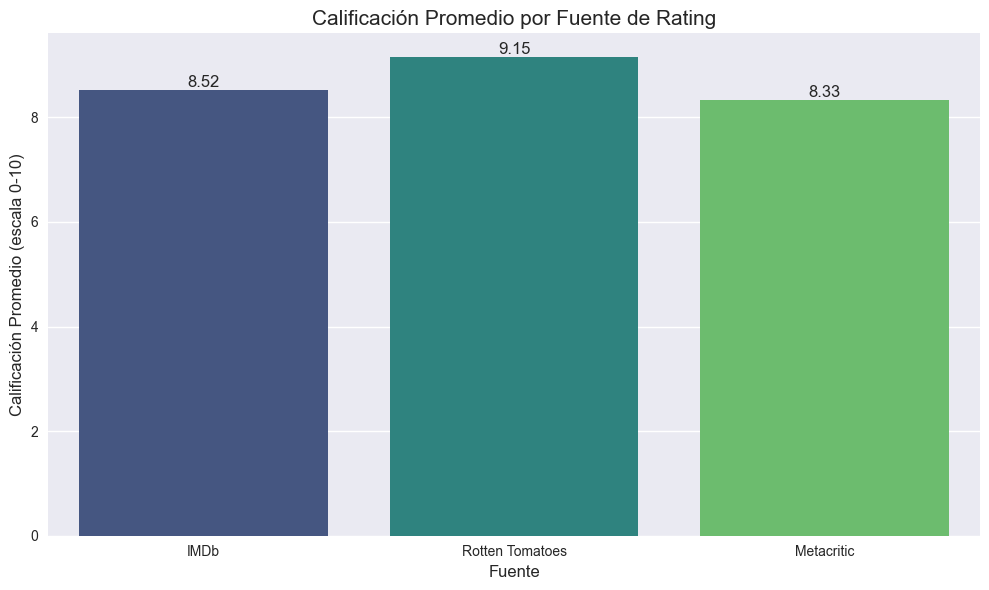

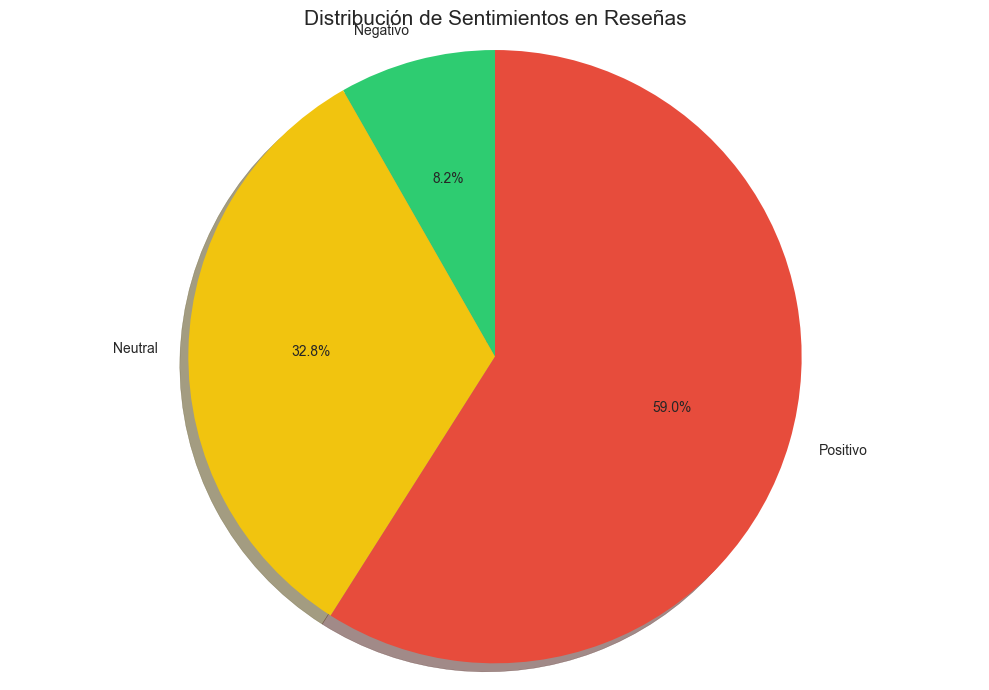

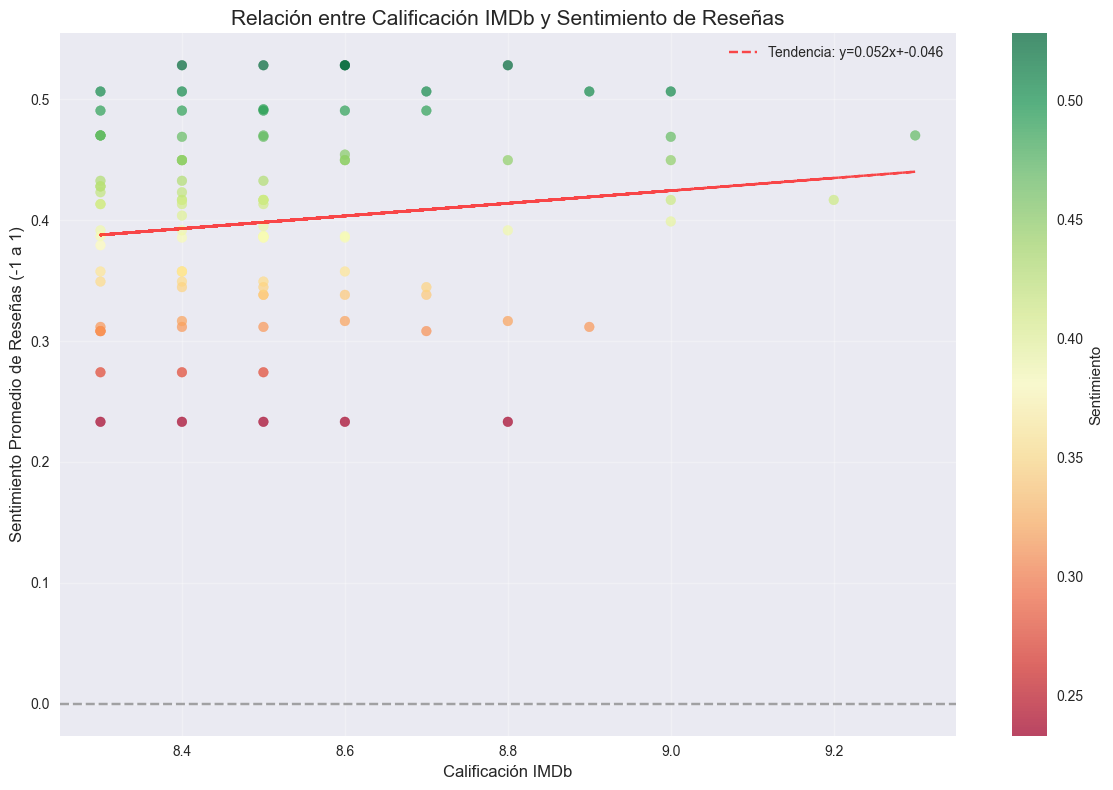

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_8741/4035645167.py:476: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='genre', y='avg_imdb', data=genres_df, palette='viridis',


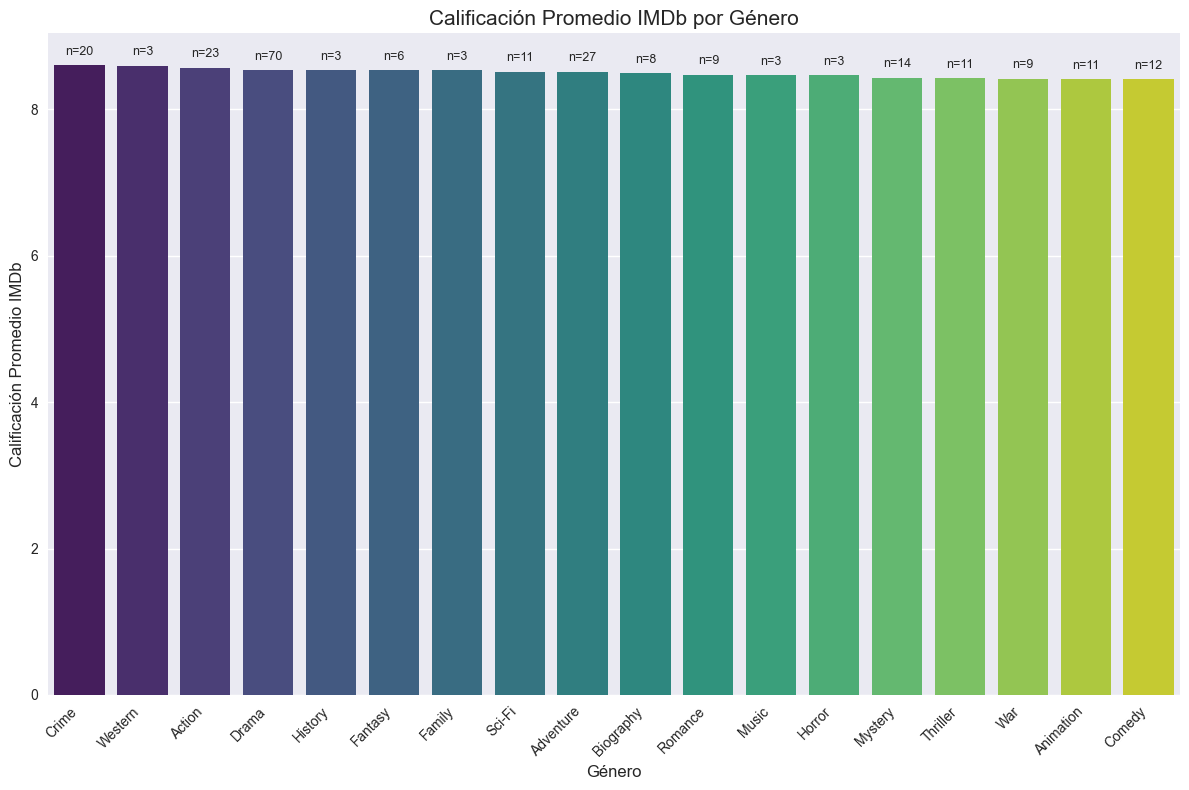

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_8741/4035645167.py:508: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Fuente de Calificación')


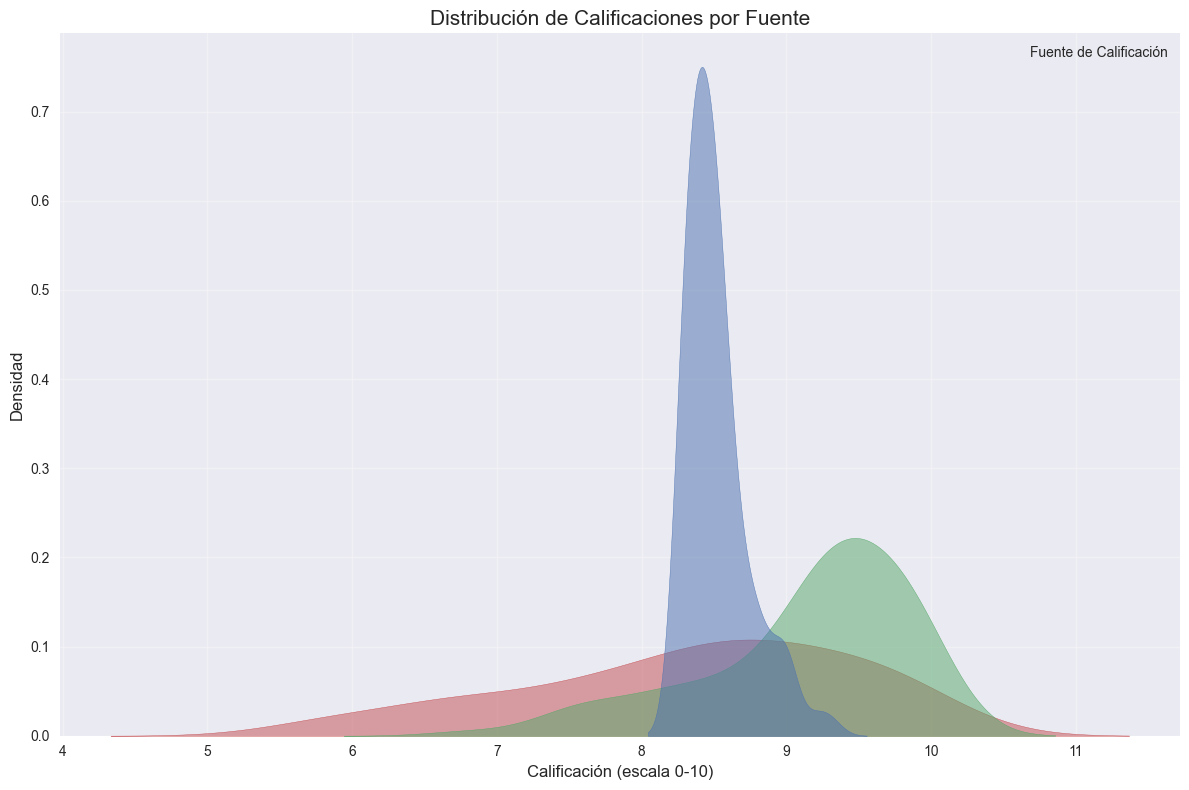

Visualizaciones generadas y mostradas exitosamente.

Visualizaciones mostradas exitosamente.

Proceso finalizado correctamente.


In [6]:
import os
import sqlite3
import requests
from dotenv import load_dotenv
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

def step_1_fetch_movies():
    """Obtiene la lista de las 100 mejores películas desde la API de IMDb."""
    load_dotenv()
    imdb_api_key = os.getenv("IMDB_API_KEY")
    omdb_api_key = os.getenv("OMDB_API_KEY")
    
    if not imdb_api_key or not omdb_api_key:
        print("Error: Las claves de API no están configuradas correctamente en el archivo .env")
        return []
    
    imdb_url = f"https://imdb-top-100-movies.p.rapidapi.com/"
    headers = {"X-RapidAPI-Key": imdb_api_key}
    
    try:
        response = requests.get(imdb_url, headers=headers)
        response.raise_for_status()
        
        movies = response.json()
        if not isinstance(movies, list):
            print("Error: La API IMDb no devolvió una lista de películas.")
            return []
        
        request_count = 0
        
        for movie in movies:
            imdb_id = movie.get("imdbid", None)
            if not imdb_id:
                print("Advertencia: Película sin IMDb ID encontrada, omitiendo...")
                continue
            
            if request_count >= 100:
                print(f"Se alcanzó el límite de {request_count} solicitudes a OMDb API.")
                break
                
            # Obtener datos completos de la película incluyendo posibles reseñas
            movie_details = step_1_fetch_movie_details(imdb_id, omdb_api_key)
            
            # Añadir las calificaciones
            movie["ratings"] = movie_details.get("ratings", {})
            
            # Obtener reseñas (de la API o generadas)
            movie["reviews"] = step_2_fetch_real_or_sample_reviews(imdb_id, movie_details)
            
            request_count += 1
            
        return movies
    except requests.RequestException as e:
        print(f"Error al conectar con la API de IMDb: {e}")
        return []

def step_1_fetch_movie_details(imdb_id, omdb_api_key):
    """Obtiene detalles completos de una película usando OMDb API."""
    omdb_url = f"http://www.omdbapi.com/?i={imdb_id}&plot=full&apikey={omdb_api_key}"
    
    try:
        response = requests.get(omdb_url)
        response.raise_for_status()
        
        data = response.json()
        
        # Procesar calificaciones
        ratings = {}
        for rating in data.get("Ratings", []):
            source, value = rating["Source"], rating["Value"]
            try:
                if "%" in value:
                    ratings[source] = float(value.replace("%", "")) / 10
                elif "/" in value:
                    num, denom = value.split("/")
                    if float(denom) == 10:
                        ratings[source] = float(num)
                    else:
                        ratings[source] = (float(num) / float(denom)) * 10
                else:
                    ratings[source] = float(value)
            except (ValueError, TypeError):
                print(f"No se pudo convertir el valor '{value}' para la fuente '{source}'")
        
        # Crear objeto de detalles
        movie_details = {
            "ratings": ratings,
            "plot": data.get("Plot", ""),
            "actors": data.get("Actors", ""),
            "director": data.get("Director", ""),
            "language": data.get("Language", ""),
        }
        
        return movie_details
    except requests.RequestException as e:
        print(f"Error al obtener detalles para IMDb ID {imdb_id}: {e}")
        return {"ratings": {}}

def step_2_fetch_real_or_sample_reviews(imdb_id, movie_details):
    """
    Intenta obtener reseñas reales o genera reseñas de ejemplo en inglés.
    
    En un entorno real, podrías:
    1. Usar la API de IMDb si tienes acceso (requiere suscripción)
    2. Usar web scraping ético (siguiendo términos de servicio)
    3. Usar otra API de reseñas de películas
    
    Aquí generamos reseñas basadas en los detalles de la película.
    """
    # Intentamos usar la trama y los actores para generar reseñas más personalizadas
    plot = movie_details.get("plot", "")
    actors = movie_details.get("actors", "")
    director = movie_details.get("director", "")
    
    # Variedad de reseñas positivas
    positive_reviews = [
        f"Excellent movie with a fascinating plot. Highly recommended! The acting by {actors} was superb. #{imdb_id}",
        f"A masterpiece directed by {director}. The cinematography and story were exceptional. #{imdb_id}",
        f"One of the best films I've ever seen. The narrative flow kept me engaged throughout. #{imdb_id}"
    ]
    
    # Variedad de reseñas mixtas
    mixed_reviews = [
        f"Good performances by the cast, but the story could have been better developed. Still worth watching. #{imdb_id}",
        f"Interesting concept and decent execution. Some scenes drag on too long, but overall a solid film. #{imdb_id}",
        f"The visuals are stunning, but the character development feels incomplete. A mixed experience. #{imdb_id}"
    ]
    
    # Variedad de reseñas negativas
    negative_reviews = [
        f"Unfortunately, this film didn't live up to the hype. The plot had too many holes and the pacing was off. #{imdb_id}",
        f"Despite the talented cast, the movie fails to deliver a cohesive story. Disappointing overall. #{imdb_id}",
        f"The direction seemed unfocused and the ending was unsatisfying. I wouldn't recommend it. #{imdb_id}"
    ]
    
    # Crear una mezcla de reseñas con diferentes sentimientos
    import random
    reviews = []
    
    # Añadir reseñas aleatorias con diferentes sentimientos (mayoría positivas)
    reviews.extend(random.sample(positive_reviews, 2))  # 2 positivas
    reviews.append(random.choice(mixed_reviews))       # 1 mixta
    reviews.append(random.choice(negative_reviews))    # 1 negativa
    
    # Analizar sentimientos
    analyzed_reviews = step_2_analyze_reviews(reviews)
    return analyzed_reviews

def step_2_analyze_reviews(reviews):
    """Analiza sentimientos en las reseñas con TextBlob."""
    results = []
    for review in reviews:
        try:
            analysis = TextBlob(review)
            sentiment_score = analysis.sentiment.polarity
            results.append((review, sentiment_score))
            print(f"Análisis de sentimiento para: '{review[:50]}...': {sentiment_score}")
        except Exception as e:
            print(f"Error al analizar reseña: {e}")
            results.append((review, 0.0))
    return results

def step_3_create_database():
    """Elimina la base de datos anterior y crea una nueva en SQLite."""
    if os.path.exists("movies.db"):
        os.remove("movies.db")
    
    try:
        conn = sqlite3.connect("movies.db")
        cursor = conn.cursor()
        
        cursor.execute("""
            CREATE TABLE movies (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                imdb_id TEXT UNIQUE,
                title TEXT,
                year INTEGER,
                description TEXT,
                genre TEXT,
                rating_imdb REAL,
                rating_rt REAL,
                rating_metacritic REAL
            )
        """)
        cursor.execute("""
            CREATE TABLE reviews (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                imdb_id TEXT,
                review TEXT,
                sentiment_score REAL,
                FOREIGN KEY (imdb_id) REFERENCES movies(imdb_id)
            )
        """)
        
        conn.commit()
        conn.close()
        return True
    except sqlite3.Error as e:
        print(f"Error al crear la base de datos: {e}")
        return False

def step_3_insert_data(movies):
    """Inserta los datos de las películas y reseñas en la base de datos."""
    try:
        conn = sqlite3.connect("movies.db")
        cursor = conn.cursor()
        
        movies_inserted = 0
        reviews_inserted = 0
        
        for movie in movies:
            imdb_id = movie.get("imdbid")
            if not imdb_id:
                continue
                
            ratings = movie.get("ratings", {})
            
            # Insertar película
            try:
                cursor.execute("""
                    INSERT INTO movies (imdb_id, title, year, description, genre, rating_imdb, rating_rt, rating_metacritic)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?)""",
                    (
                        imdb_id, 
                        movie.get("title"), 
                        movie.get("year"), 
                        movie.get("description"), 
                        ",".join(movie.get("genre", [])),
                        ratings.get("Internet Movie Database"),
                        ratings.get("Rotten Tomatoes"),
                        ratings.get("Metacritic")
                    )
                )
                movies_inserted += 1
                
                # Insertar reseñas
                for review, sentiment in movie.get("reviews", []):
                    cursor.execute("""
                        INSERT INTO reviews (imdb_id, review, sentiment_score)
                        VALUES (?, ?, ?)""",
                        (imdb_id, review, sentiment)
                    )
                    reviews_inserted += 1
                    
            except sqlite3.IntegrityError:
                print(f"La película con ID {imdb_id} ya existe en la base de datos. Omitiendo.")
        
        conn.commit()
        conn.close()
        
        return movies_inserted, reviews_inserted
    except sqlite3.Error as e:
        print(f"Error al insertar datos en la base de datos: {e}")
        return 0, 0

def step_4_verify_database():
    """Verifica que los datos se hayan insertado correctamente."""
    try:
        conn = sqlite3.connect("movies.db")
        cursor = conn.cursor()
        
        # Verificar películas
        cursor.execute("SELECT COUNT(*) FROM movies")
        movie_count = cursor.fetchone()[0]
        
        # Verificar reseñas
        cursor.execute("SELECT COUNT(*) FROM reviews")
        review_count = cursor.fetchone()[0]
        
        # Verificar distribución de sentimientos
        cursor.execute("""
            SELECT 
                CASE 
                    WHEN sentiment_score > 0.3 THEN 'Positivo' 
                    WHEN sentiment_score < -0.3 THEN 'Negativo' 
                    ELSE 'Neutral' 
                END as sentimiento,
                COUNT(*) as total
            FROM reviews
            GROUP BY sentimiento
        """)
        sentiment_distribution = cursor.fetchall()
        
        # Verificar relación y mostrar ejemplos para cada tipo de sentimiento
        cursor.execute("""
            SELECT m.title, r.review, r.sentiment_score
            FROM movies m
            JOIN reviews r ON m.imdb_id = r.imdb_id
            ORDER BY r.sentiment_score DESC
            LIMIT 3
        """)
        positive_examples = cursor.fetchall()
        
        cursor.execute("""
            SELECT m.title, r.review, r.sentiment_score
            FROM movies m
            JOIN reviews r ON m.imdb_id = r.imdb_id
            ORDER BY r.sentiment_score
            LIMIT 3
        """)
        negative_examples = cursor.fetchall()
        
        conn.close()
        
        return {
            "movies": movie_count,
            "reviews": review_count,
            "sentiment_distribution": sentiment_distribution,
            "positive_examples": positive_examples,
            "negative_examples": negative_examples
        }
    except sqlite3.Error as e:
        print(f"Error al verificar la base de datos: {e}")
        return None
# Ejecución del flujo completo
def main():
    print("Iniciando proceso de extracción y análisis de películas...")
    
    # Paso 1: Obtener datos
    movies = step_1_fetch_movies()
    if not movies:
        print("No se pudieron obtener películas. Finalizando proceso.")
        return
    
    print(f"Se obtuvieron datos de {len(movies)} películas.")
    
    # Paso 2: Crear base de datos
    if not step_3_create_database():
        print("Error al crear la base de datos. Finalizando proceso.")
        return
    
    print("Base de datos creada exitosamente.")
    
    # Paso 3: Insertar datos
    movies_inserted, reviews_inserted = step_3_insert_data(movies)
    print(f"Se insertaron {movies_inserted} películas y {reviews_inserted} reseñas en la base de datos.")
    
    # Paso 4: Verificar datos
    verification = step_4_verify_database()
    if verification:
        print(f"\nVerificación completa: {verification['movies']} películas y {verification['reviews']} reseñas en la base de datos.")
        
        print("\nDistribución de sentimientos:")
        for sentiment, count in verification.get("sentiment_distribution", []):
            print(f"- {sentiment}: {count} reseñas")
        
        print("\nEjemplos de reseñas positivas:")
        for movie_title, review, sentiment in verification.get("positive_examples", []):
            print(f"- {movie_title}: \"{review[:70]}...\" (Sentimiento: {sentiment:.2f})") # Se ajusta el número de caracteres a mostrar
        
        print("\nEjemplos de reseñas negativas:")
        for movie_title, review, sentiment in verification.get("negative_examples", []):
            print(f"- {movie_title}: \"{review[:70]}...\" (Sentimiento: {sentiment:.2f})") # Se ajusta el número de caracteres a mostrar
    
    print("\nProceso finalizado correctamente.")
    
def step_5_visualize_data():
    """
    Crea visualizaciones a partir de los datos almacenados en la base de datos.
    Genera gráficos para calificaciones, sentimientos y relaciones entre variables.
    Muestra los gráficos en la ejecución del código en lugar de guardarlos como imágenes.
    """
    try:
        # Configurar estilo de las gráficas
        plt.style.use('seaborn-v0_8')
        
        # Conectar a la base de datos
        conn = sqlite3.connect("movies.db")
        
        # 1. Visualización de calificaciones promedio por fuente
        query_ratings = """
            SELECT 
                AVG(rating_imdb) as 'IMDb',
                AVG(rating_rt) as 'Rotten Tomatoes',
                AVG(rating_metacritic) as 'Metacritic'
            FROM movies
            WHERE rating_imdb IS NOT NULL 
              OR rating_rt IS NOT NULL 
              OR rating_metacritic IS NOT NULL
        """
        ratings_df = pd.read_sql_query(query_ratings, conn)
        
        # Transformar a formato largo para facilitar la visualización
        ratings_long = pd.melt(ratings_df, var_name='Fuente', value_name='Calificación')
        
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Fuente', y='Calificación', data=ratings_long, palette='viridis')
        plt.title('Calificación Promedio por Fuente de Rating', fontsize=15)
        plt.xlabel('Fuente', fontsize=12)
        plt.ylabel('Calificación Promedio (escala 0-10)', fontsize=12)
        
        # Añadir etiquetas de valor en cada barra
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'bottom', fontsize=12)
        
        plt.tight_layout()
        plt.show()  # Mostrar gráfico en lugar de guardarlo
        
        # 2. Distribución de sentimientos en reseñas
        query_sentiment = """
            SELECT 
                CASE 
                    WHEN sentiment_score > 0.3 THEN 'Positivo' 
                    WHEN sentiment_score < -0.3 THEN 'Negativo' 
                    ELSE 'Neutral' 
                END as sentimiento,
                COUNT(*) as total
            FROM reviews
            GROUP BY sentimiento
        """
        sentiment_df = pd.read_sql_query(query_sentiment, conn)
        
        plt.figure(figsize=(10, 7))
        colors = ['#2ecc71', '#f1c40f', '#e74c3c']  # Verde, amarillo, rojo
        plt.pie(sentiment_df['total'], labels=sentiment_df['sentimiento'], 
                autopct='%1.1f%%', startangle=90, colors=colors, shadow=True)
        plt.title('Distribución de Sentimientos en Reseñas', fontsize=15)
        plt.axis('equal')  # Asegura que el gráfico sea circular
        plt.tight_layout()
        plt.show()  # Mostrar gráfico en lugar de guardarlo
        
        # 3. Relación entre calificación IMDb y sentimiento de reseñas
        query_imdb_sentiment = """
            SELECT m.imdb_id, m.title, m.rating_imdb, AVG(r.sentiment_score) as avg_sentiment
            FROM movies m
            JOIN reviews r ON m.imdb_id = r.imdb_id
            WHERE m.rating_imdb IS NOT NULL
            GROUP BY m.imdb_id
        """
        imdb_sentiment_df = pd.read_sql_query(query_imdb_sentiment, conn)
        
        plt.figure(figsize=(12, 8))
        plt.scatter(imdb_sentiment_df['rating_imdb'], imdb_sentiment_df['avg_sentiment'], 
                   alpha=0.7, c=imdb_sentiment_df['avg_sentiment'], cmap='RdYlGn')
        
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)  # Línea de sentimiento neutral
        
        plt.title('Relación entre Calificación IMDb y Sentimiento de Reseñas', fontsize=15)
        plt.xlabel('Calificación IMDb', fontsize=12)
        plt.ylabel('Sentimiento Promedio de Reseñas (-1 a 1)', fontsize=12)
        plt.colorbar(label='Sentimiento')
        plt.grid(True, alpha=0.3)
        
        # Añadir línea de tendencia
        z = np.polyfit(imdb_sentiment_df['rating_imdb'], imdb_sentiment_df['avg_sentiment'], 1)
        p = np.poly1d(z)
        plt.plot(imdb_sentiment_df['rating_imdb'], p(imdb_sentiment_df['rating_imdb']), 
                "r--", alpha=0.7, label=f"Tendencia: y={z[0]:.3f}x+{z[1]:.3f}")
        plt.legend()
        
        plt.tight_layout()
        plt.show()  # Mostrar gráfico en lugar de guardarlo
        
        # 4. Análisis por género
        query_genres = """
            SELECT genre, AVG(rating_imdb) as avg_imdb, COUNT(*) as count
            FROM (
                SELECT m.imdb_id, m.rating_imdb, trim(value) as genre
                FROM movies m, json_each('["' || replace(m.genre, ',', '","') || '"]')
                WHERE m.rating_imdb IS NOT NULL
            )
            GROUP BY genre
            HAVING count >= 3
            ORDER BY avg_imdb DESC
        """
        genres_df = pd.read_sql_query(query_genres, conn)
        
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='genre', y='avg_imdb', data=genres_df, palette='viridis', 
                         order=genres_df.sort_values('avg_imdb', ascending=False)['genre'])
        
        plt.title('Calificación Promedio IMDb por Género', fontsize=15)
        plt.xlabel('Género', fontsize=12)
        plt.ylabel('Calificación Promedio IMDb', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        # Añadir número de películas por género
        for i, p in enumerate(ax.patches):
            ax.annotate(f'n={genres_df.iloc[i]["count"]}', 
                       (p.get_x() + p.get_width() / 2., p.get_height() + 0.1), 
                       ha = 'center', va = 'bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()  # Mostrar gráfico en lugar de guardarlo
        
        # 6. Distribución de calificaciones por fuente (se ha saltado el 5 que era WordCloud)
        query_all_ratings = """
            SELECT rating_imdb as IMDb, rating_rt as 'Rotten Tomatoes', 
                   rating_metacritic as Metacritic
            FROM movies 
            WHERE rating_imdb IS NOT NULL
        """
        all_ratings_df = pd.read_sql_query(query_all_ratings, conn)
        
        plt.figure(figsize=(12, 8))
        sns.kdeplot(data=all_ratings_df, fill=True, alpha=0.5)
        plt.title('Distribución de Calificaciones por Fuente', fontsize=15)
        plt.xlabel('Calificación (escala 0-10)', fontsize=12)
        plt.ylabel('Densidad', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(title='Fuente de Calificación')
        plt.tight_layout()
        plt.show()  # Mostrar gráfico en lugar de guardarlo
        
        conn.close()
        
        print("Visualizaciones generadas y mostradas exitosamente.")
        return True
        
    except Exception as e:
        print(f"Error al crear visualizaciones: {e}")
        return False

# Modificación de la función main para incluir visualización
def main():
    print("Iniciando proceso de extracción y análisis de películas...")
    
    # Paso 1: Obtener datos
    movies = step_1_fetch_movies()
    if not movies:
        print("No se pudieron obtener películas. Finalizando proceso.")
        return
    
    print(f"Se obtuvieron datos de {len(movies)} películas.")
    
    # Paso 2: Crear base de datos
    if not step_3_create_database():
        print("Error al crear la base de datos. Finalizando proceso.")
        return
    
    print("Base de datos creada exitosamente.")
    
    # Paso 3: Insertar datos
    movies_inserted, reviews_inserted = step_3_insert_data(movies)
    print(f"Se insertaron {movies_inserted} películas y {reviews_inserted} reseñas en la base de datos.")
    
    # Paso 4: Verificar datos
    verification = step_4_verify_database()
    if verification:
        print(f"\nVerificación completa: {verification['movies']} películas y {verification['reviews']} reseñas en la base de datos.")
        
        print("\nDistribución de sentimientos:")
        for sentiment, count in verification.get("sentiment_distribution", []):
            print(f"- {sentiment}: {count} reseñas")
        
        print("\nEjemplos de reseñas positivas:")
        for movie_title, review, sentiment in verification.get("positive_examples", []):
            print(f"- {movie_title}: \"{review[:70]}...\" (Sentimiento: {sentiment:.2f})")
        
        print("\nEjemplos de reseñas negativas:")
        for movie_title, review, sentiment in verification.get("negative_examples", []):
            print(f"- {movie_title}: \"{review[:70]}...\" (Sentimiento: {sentiment:.2f})")
    
    # Paso 5: Visualizar datos 
    print("\nCreando y mostrando visualizaciones...")
    if step_5_visualize_data():
        print("\nVisualizaciones mostradas exitosamente.")
    else:
        print("\nError al crear visualizaciones.")
    
    print("\nProceso finalizado correctamente.")

if __name__ == "__main__":
    main()